In [2]:
import os
import sys
import numpy as np
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from PIL import Image

In [15]:
warnings.filterwarnings("ignore")
checkpoint = ModelCheckpoint('../Scripts/best_model_lenet.h5', monitor='val_loss', save_best_only=True, mode='min')

?


In [6]:
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("Có GPU sẵn sàng.")
else:
    print("Không tìm thấy GPU.")
    sys.exit()

Có GPU sẵn sàng.


In [7]:
def load_data(data_dir):
    images = []
    labels = []
    class_names = os.listdir(data_dir)  # Lấy tên các lớp từ thư mục

    for label in class_names:
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):  # Kiểm tra xem đây có phải là thư mục không
            for filename in os.listdir(class_dir):
                if filename.endswith('.png') or filename.endswith('.jpg'):  # Kiểm tra định dạng tệp
                    img_path = os.path.join(class_dir, filename)
                    image = Image.open(img_path).convert('RGB')  # Chuyển đổi thành ảnh RGB
                    image = image.resize((32, 32))  # Thay đổi kích thước ảnh
                    images.append(np.array(image))
                    labels.append(class_names.index(label))  # Gán nhãn lớp

    return np.array(images), to_categorical(np.array(labels), num_classes=36)  # Trả về mảng NumPy của ảnh và nhãn

In [8]:
train_dir = r'..\Data\Gesture Image Pre-Processed Data'
test_dir = r'..\Data\Gesture Image Pre-Processed Data - Test'

# Tải dữ liệu
X_train, Y_train = load_data(train_dir)
X_test, Y_test = load_data(test_dir)

In [16]:
model = Sequential()

# Lớp tích chập đầu tiên
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'))  # 3 kênh màu
model.add(BatchNormalization())
model.add(AveragePooling2D())

# Lớp tích chập thứ hai
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D())

# Lớp tích chập thứ ba
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D())

# Chuyển đổi đặc trưng thành vector
model.add(Flatten())

model.add(Dense(512, activation='relu'))  # Tăng số lượng nơ-ron
model.add(Dropout(0.5))  # Thêm lớp Dropout để giảm overfitting

model.add(Dense(256, activation='relu'))  # Tăng số lượng nơ-ron
model.add(Dropout(0.5))  # Thêm lớp Dropout để giảm overfitting

model.add(Dense(128, activation='relu'))  # Tăng số lượng nơ-ron
model.add(Dropout(0.5))  # Thêm lớp Dropout để giảm overfitting

# Lớp output với số lớp tương ứng
model.add(Dense(36, activation='softmax'))  # 36 lớp

# Biên dịch mô hình
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

# Huấn luyện mô hình
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test), batch_size=64,
                callbacks=[checkpoint, reduce_lr, early_stop])

# Lưu mô hình
#model.save('../Scripts/hand_sign_recognition_lenet5.h5')

Epoch 1/20
844/844 [==============================] - 8s 9ms/step - loss: 0.8909 - accuracy: 0.7422 - val_loss: 0.0051 - val_accuracy: 0.9991 - lr: 0.0010
Epoch 2/20
844/844 [==============================] - 7s 9ms/step - loss: 0.0825 - accuracy: 0.9761 - val_loss: 0.7075 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 3/20
844/844 [==============================] - 7s 9ms/step - loss: 0.0486 - accuracy: 0.9868 - val_loss: 0.0022 - val_accuracy: 0.9996 - lr: 0.0010
Epoch 4/20
844/844 [==============================] - 7s 8ms/step - loss: 0.0326 - accuracy: 0.9915 - val_loss: 0.0450 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 5/20
844/844 [==============================] - 7s 8ms/step - loss: 0.0385 - accuracy: 0.9910 - val_loss: 1.2948e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/20
844/844 [==============================] - 7s 8ms/step - loss: 0.0265 - accuracy: 0.9938 - val_loss: 6.6671e-04 - val_accuracy: 0.9997 - lr: 0.0010
Epoch 7/20
844/844 [==============================] - 7s 8ms/s

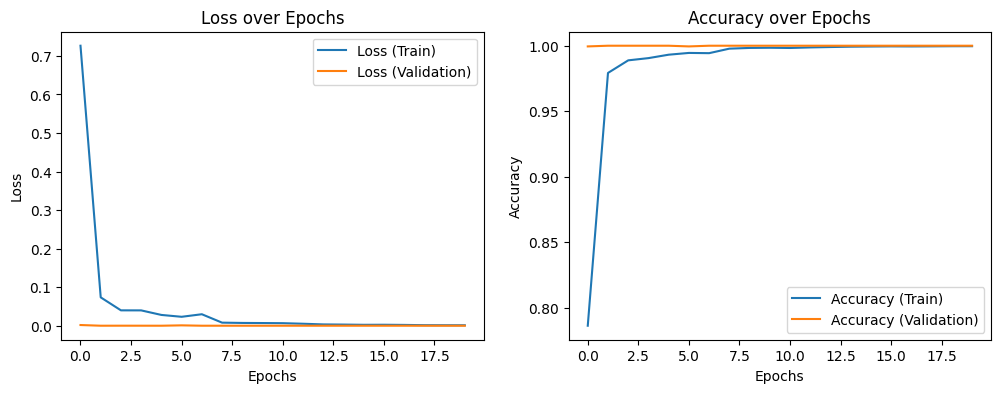

In [13]:
plt.figure(figsize=(12, 4))

# Loss cho tập huấn luyện
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy cho tập huấn luyện
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy (Train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (Validation)')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()